In [243]:
import json
import pandas as pd
import requests
import twitter
import polyglot

In [248]:
import matplotlib.pyplot as plt
import wordcloud

In [ ]:
api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')

In [5]:

# reading the data from the file 
with open('twitter_dict.txt') as f: 
    data = f.read() 
    authentification = json.loads(data) 

In [11]:
banks = {"Česká spořitelna":"ceskasporitelna",
         "Československá obchodní banka":"csob_cz",
         "Komerční Banka":"komercka",
         "UniCredit":"unicredit_czsk",
         "Raiffeisenbank":"raiffeisencz"}

In [12]:
banks

{'Česká spořitelna': 'ceskasporitelna',
 'Československá obchodní banka': 'csob_cz',
 'Komerční Banka': 'komercka',
 'UniCredit': 'unicredit_czsk',
 'Raiffeisenbank': 'raiffeisencz'}

In [188]:
class Comparison_collection():
    '''
    Class containing methods for comparing among different twitter users posts and their mentions posts. 
    '''
    
    def __init__(self,dictionary, authentification):
        '''
        Loads a dictionary with {"full_name":"twitter_handle"} pairs and saves this logic
        also creates an python-twitter API object based on a dictionary with API keys,
        consumer key and secret must be called API_key and API_secret_key respectively,
        access token key and access token secret must be called Access_token and Access_token_secret respectively
        '''

        self.users = dictionary
        
    
        self.api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')
    
    def create_user_data(self):
        
        for name in self.users:
            
            self.accounts = {name: Twitter_user(self.users[name], self.api) for name in self.users}
            
    def get_users_tweets(self):
        
        for name in self.users:
            
            self.accounts[name].gather_tweets()
    

In [189]:
cz_banks = Comparison_collection(banks, authentification)

In [190]:
cz_banks.create_user_data()

In [191]:
cz_banks.get_users_tweets()

In [ ]:
contributors

In [195]:
cz_banks.accounts['Česká spořitelna'].timeline[1].contributors

In [200]:
cz_banks.accounts['Česká spořitelna'].timeline[1].followers_count

AttributeError: 'Status' object has no attribute 'followers_count'

In [202]:
dir(cz_banks.accounts['Česká spořitelna'].timeline[1])

['AsDict',
 'AsJsonString',
 'NewFromJsonDict',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_json',
 'contributors',
 'coordinates',
 'created_at',
 'created_at_in_seconds',
 'current_user_retweet',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'hashtags',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'location',
 'media',
 'param_defaults',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'scopes',
 'source',
 'text',
 'truncated',
 'tweet_mode',
 'urls',
 'user',
 'user_mentions',
 'withheld_c

In [209]:
dir(cz_banks.accounts['Česká spořitelna'].timeline[1]._json)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [219]:
cz_banks.accounts['Česká spořitelna'].timeline[1]._json['user']

{'id': 34302619,
 'id_str': '34302619',
 'name': 'Česká spořitelna',
 'screen_name': 'Ceskasporitelna',
 'location': 'Česká republika',
 'description': 'Jsme nejdostupnější bankou v České republice. Osobní poradenství a péči nabízíme každému klientovi bez rozdílu.',
 'url': 'http://t.co/1bv7PSfQoF',
 'entities': {'url': {'urls': [{'url': 'http://t.co/1bv7PSfQoF',
     'expanded_url': 'http://www.csas.cz',
     'display_url': 'csas.cz',
     'indices': [0, 22]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 4424,
 'friends_count': 1399,
 'listed_count': 57,
 'created_at': 'Wed Apr 22 15:32:09 +0000 2009',
 'favourites_count': 2369,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 5904,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'CCECF4',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.p

In [218]:
cz_banks.accounts['Česká spořitelna'].timeline[1]._json['user']['friends_count']

1399

In [221]:
cz_banks.accounts['Česká spořitelna'].timeline[1]._json['user']['favourites_count']
cz_banks.accounts['Česká spořitelna'].timeline[1]._json['user']['followers_count']
cz_banks.accounts['Česká spořitelna'].timeline[1]._json['user']['friends_count']

2369

In [222]:
cz_banks.accounts['Česká spořitelna'].timeline[1]._json['user']['followers_count']

4424

In [194]:
 ['contributors',
 'coordinates',
 'created_at',
 'created_at_in_seconds',
 'current_user_retweet',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'hashtags',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'location',
 'media',
 'param_defaults',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'scopes',
 'source',
 'text',
 'truncated',
 'tweet_mode',
 'urls',
 'user',
 'user_mentions',
 'withheld_copyright',
 'withheld_in_countries',
 'withheld_scope'
 ]

['contributors',
 'coordinates',
 'created_at',
 'created_at_in_seconds',
 'current_user_retweet',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'hashtags',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'location',
 'media',
 'param_defaults',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'scopes',
 'source',
 'text',
 'truncated',
 'tweet_mode',
 'urls',
 'user',
 'user_mentions',
 'withheld_copyright',
 'withheld_in_countries',
 'withheld_scope']

In [193]:
dir(cz_banks.accounts['Česká spořitelna'].timeline[1])

['AsDict',
 'AsJsonString',
 'NewFromJsonDict',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_json',
 'contributors',
 'coordinates',
 'created_at',
 'created_at_in_seconds',
 'current_user_retweet',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'hashtags',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'location',
 'media',
 'param_defaults',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'scopes',
 'source',
 'text',
 'truncated',
 'tweet_mode',
 'urls',
 'user',
 'user_mentions',
 'withheld_c

In [185]:
dir(cz_banks.accounts['Česká spořitelna'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'api',
 'get_mentions',
 'get_timeline',
 'twitter_handle']

In [164]:
cz_banks.individual_users['Česká spořitelna']

In [ ]:
twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')

In [376]:
class Twitter_user():
    '''
    Class containing timeline (list of all recent tweets), mentions statistics about their posts
    
    '''
    
    def __init__(self, twitter_handle, api):

        self.twitter_handle = twitter_handle
        self.api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')
        
    def get_timeline(self):
        self.timeline = self.api.GetUserTimeline(screen_name=self.twitter_handle, count=2)
        
    def get_mentions(self):
        self.mentions = self.api.GetSearch(term=self.twitter_handle,include_entities=True, count=2, result_type='recent')
        
    def gather_tweets(self):
        self.get_mentions()
        self.get_timeline()
        
    def get_account_details(self):
        '''
        requires at least one tweet in the timeline attribute Call get_timeline() or gather_tweets() to construct it
        '''
        self.details = {}
        self.detail_atributes_required = ('favourites_count', 'followers_count', 'friends_count', 'statuses_count')
        self.details = {k: self.timeline[1]._json['user'][k] for k in self.detail_atributes_required}
        print(self.details)
        
        
        
        
    def extract_mention_user_data(self):
        
        self.interesting_atributes = ['screen_name', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'location']
        for num, tweet in enumerate(rajf.mentions, start=0):
            self.mentions[num].user_info = (
                {k: self.mentions[num]._json['user'][k] for k in self.interesting_atributes}
            )
            self.mentions[num].user_info_pd = pd.DataFrame( self.mentions[num].user_info,
                                                           index =  [self.mentions[num].user_info['screen_name']])
        
    def extract_mention_tweet_data(self):    
        
        tweet_attributes = ['full_text', 'lang', 'retweet_count', 'source']
            
        for num, tweet in enumerate(rajf.mentions, start=0):
            self.mentions[num].tweet_info = (
                {k: self.mentions[num]._json[k] for k in tweet_attributes}
            )
            
        
    def generate_mentions_pdf(self):
        self.pdf_list = []
        for num, tweet in enumerate(rajf.mentions, start=0):
            self.mentions[num].tweet_pd = pd.DataFrame( {**self.mentions[num].user_info, **self.mentions[num].tweet_info},
                                                           index =  [self.mentions[num].user_info['screen_name']])
            self.pdf_list = self.pdf_list.append(self.mentions[num].tweet_pd)
        
    def generate_pdf(self):
        self.tweets_pd = pd.concat([self.mentions[num].tweet_pd] for num in list(range(0, len(self.mentions))))

In [354]:
import itertools

In [368]:
list(range(0, len(rajf.mentions)))

[0, 1]

In [ ]:
rajf.

In [377]:
rajf = Twitter_user('raiffeisencz', authentification)

In [378]:
rajf.gather_tweets()

In [379]:
rajf.extract_mention_user_data()

In [380]:
rajf.extract_mention_tweet_data()

In [381]:
rajf.generate_mentions_pdf()

AttributeError: 'NoneType' object has no attribute 'append'

In [250]:
type(rajf.mentions)

list

In [353]:
rajf.mentions[1].tweet_info

{'full_text': '@RaiffeisenCZ Bodejť by nemělo tolik stažení, když si aplikaci MUSELI klienti pořídit. Zatím jsem potřeboval využít aplikaci 4x a z toho 3x nefungovala nebo zafungovala několik hodin po chvíli, kdy bylo potřeba ověření. Tedy další výkvět do vaší sbírky "kvalitních" aplikací..',
 'lang': 'cs',
 'retweet_count': 0,
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'}

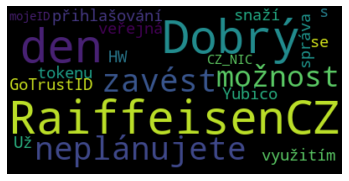

In [249]:
text = rajf.mentions[0].full_text

wordcloud = wordcloud.WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
text = " ".join(review for review in df.description)

In [238]:
rajf.get_mentions()

In [241]:
rajf.mentions[1].__dict__

{'param_defaults': {'contributors': None,
  'coordinates': None,
  'created_at': None,
  'current_user_retweet': None,
  'favorite_count': None,
  'favorited': None,
  'full_text': None,
  'geo': None,
  'hashtags': None,
  'id': None,
  'id_str': None,
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_user_id': None,
  'lang': None,
  'location': None,
  'media': None,
  'place': None,
  'possibly_sensitive': None,
  'quoted_status': None,
  'quoted_status_id': None,
  'quoted_status_id_str': None,
  'retweet_count': None,
  'retweeted': None,
  'retweeted_status': None,
  'scopes': None,
  'source': None,
  'text': None,
  'truncated': None,
  'urls': None,
  'user': None,
  'user_mentions': None,
  'withheld_copyright': None,
  'withheld_in_countries': None,
  'withheld_scope': None},
 'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Jan 01 20:30:09 +0000 2021',
 'current_user_retweet': None,
 'favorite_count': 0,
 'favorited': False,


In [78]:
api = twitter.Api(consumer_key=authentification['API_key'],
                  consumer_secret=authentification['API_secret_key'],
                  access_token_key=authentification['Access_token'],
                  access_token_secret=authentification['Access_token_secret'],
                 tweet_mode='extended')

In [82]:
api.VerifyCredentials()

User(ID=237874317, ScreenName=Roman_Ruzica)

In [86]:
banks

{'Česká spořitelna': 'ceskasporitelna',
 'Československá obchodní banka': 'csob_cz',
 'Komerční Banka': 'komercka',
 'UniCredit': 'unicredit_czsk',
 'Raiffeisenbank': 'raiffeisencz'}